# DNA and RNA Data Multi Class Single Label  with IQR boundries
By Brandon Khuu
Last update: 5/10/2021

### Goal
Create a multi-class single label classification neural network with mRNA read data(FPKM).
The classes being classfied are Control(patient is not Autistic), 15q duplication(patient is Autistic), and 16p11 deletion(patient is autisitc)

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import the data

Import the raw RNA data. The indexes are the genes. The header row are the different samples.

In [2]:
#import  raw data data
rna = pd.read_csv('Organoid Files/all_autism_fpkm.csv', header=0, low_memory=False)
rna.head()

,Unnamed: 0,PGP1-1,PGP1-2,PGP1-3,GM23716-1,GM23716-2,GM23716-3,GM23720-1,GM23720-2,GM23720-3,...,14739x3-2,14765x2-1,14765x2-2,14765x2-3,14710x6-1,14781x16-1,14781x16-2,14781x16-3,14746x8-1,14746x8-2
0,CDK5RAP1,5.561823,2.050032,2.481599,4.396121,3.721746,2.260565,3.482430,3.136405,4.645353,...,6.594048,6.941136,7.453001,3.405732,2.784555,6.384259,3.128289,7.880060,3.388043,3.623195
1,TMEM246,9.167399,6.121957,14.205795,15.263531,14.125613,6.008471,5.544019,5.302956,7.467318,...,3.478945,4.855474,4.652040,7.574598,6.334495,7.771520,8.186893,4.857521,3.334954,6.834265
2,PKD1,4.762467,3.086031,8.663784,8.198981,10.278191,5.577455,4.226272,4.628730,7.837992,...,8.564923,6.328464,3.316495,16.091198,9.193670,7.071175,9.025883,7.076191,10.996357,3.154569
3,EDEM1,4.259699,3.888580,2.988719,3.433083,3.331196,3.524835,3.539229,3.586650,3.683216,...,5.435888,6.711067,5.737995,2.197396,2.511982,3.297171,4.009783,4.097137,1.545692,3.818004
4,LSM11,3.333153,3.064389,13.747564,13.873706,13.211928,2.783226,3.232596,3.103675,4.635612,...,2.875419,3.106984,2.572676,2.553229,3.452511,5.224131,4.728078,5.166222,1.109277,3.262106


## Data Preprocessing

### Apply Threshold for FPKM reads
-Get the mean for each gene<br>
-Remove genes that fall below the minimum threshold

In [3]:
#get index col for later
gene_names = rna['Unnamed: 0']

#remove gene name col
rna = rna.drop('Unnamed: 0', axis=1)

#create Mean column
rna['Mean'] = rna.mean(axis=1)

#create genes to drop
genes_to_drop = [i for i in range(rna.shape[0]) if rna.Mean[i] <= 2]

#drop columns
rna = rna.drop(genes_to_drop)
rna = rna.drop('Mean', axis=1)

#adjust gene list
for i in genes_to_drop:
    gene_names = gene_names.drop(i)

#Set Index
rna['Sample'] = gene_names
rna = rna.set_index('Sample')
rna = rna.T
rna.head()

Sample,CDK5RAP1,TMEM246,PKD1,EDEM1,LSM11,COL26A1,CPSF6,DCTN5,MRPS33,COPS8,...,UBE2T,PTK7,EIF2B3,CDK16,C15orf61,GSTP1,IPP,ASB3,EHD4,NRSN2
PGP1-1,5.561823,9.167399,4.762467,4.259699,3.333153,5.245319,15.288924,10.670947,15.418737,26.492518,...,36.320081,23.422699,6.506580,7.639236,1.808342,253.147425,2.624415,5.473228,9.892221,14.017985
PGP1-2,2.050032,6.121957,3.086031,3.888580,3.064389,4.530108,14.225061,11.109630,21.596005,23.446239,...,19.707959,12.679506,6.687741,7.457054,1.614225,290.182382,3.276070,7.483068,7.377414,11.613564
PGP1-3,2.481599,14.205795,8.663784,2.988719,13.747564,6.189141,18.021990,15.850792,9.871680,32.272768,...,15.002978,9.314311,6.744241,36.158595,3.626686,118.126815,2.221963,5.087976,2.392554,15.666102
GM23716-1,4.396121,15.263531,8.198981,3.433083,13.873706,5.018456,17.714552,15.832140,4.594193,30.869273,...,13.609106,9.826147,6.570986,32.786094,3.988325,103.634970,2.459700,4.626596,2.301205,16.500382
GM23716-2,3.721746,14.125613,10.278191,3.331196,13.211928,5.620373,15.806883,15.434513,7.544800,24.221830,...,13.346974,4.147004,5.990253,55.245293,3.849378,111.978695,2.494851,4.843815,2.285043,18.534124


# Remove outliers

Find and remove outliers using Interquartile upper bound

In [4]:
#Get description of data frame
rna_description = rna.describe()
rna_description

Sample,CDK5RAP1,TMEM246,PKD1,EDEM1,LSM11,COL26A1,CPSF6,DCTN5,MRPS33,COPS8,...,UBE2T,PTK7,EIF2B3,CDK16,C15orf61,GSTP1,IPP,ASB3,EHD4,NRSN2
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,...,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,4.251091,6.086961,6.339876,3.889167,3.776967,6.669858,10.786037,9.214780,14.900356,21.712939,...,18.297158,24.368090,4.830248,26.456523,2.869627,322.669800,2.539877,4.227956,5.871224,13.825605
std,1.552523,2.682573,2.993639,1.714649,2.419474,3.274987,3.707618,2.754342,6.142619,5.574753,...,8.266908,14.571598,1.818987,12.773020,0.785765,117.609148,0.815381,1.348172,2.307261,3.753525
min,1.642499,0.737503,1.373917,1.248757,1.109277,1.080013,3.361271,2.709484,4.326904,9.226015,...,6.120197,0.035749,1.403382,7.450906,1.318897,93.281158,0.819236,1.359497,1.798324,3.886283
25%,3.161636,4.813943,4.110742,3.015643,2.524728,5.057375,8.755803,7.814825,10.026822,19.559559,...,12.532685,12.706315,3.499003,18.610024,2.267118,263.567587,2.007624,3.301800,3.924975,11.386199
50%,4.102123,5.909210,6.178350,3.693254,3.106984,5.753606,10.602403,9.530601,15.258703,22.095454,...,16.674666,23.422699,4.672878,24.529242,2.825838,319.538125,2.577606,4.334588,6.071386,14.017985
75%,5.019582,7.549392,8.110570,4.456003,4.244263,7.551983,12.823286,10.599152,18.642767,24.835660,...,22.618437,29.896202,6.130695,30.623387,3.302059,394.065874,3.054825,5.066565,7.564706,16.364320
max,8.803148,15.263531,16.091198,11.888391,13.873706,17.226045,21.528132,15.850792,30.976296,42.479591,...,54.222988,63.285407,13.099090,69.826664,5.200346,584.605959,4.930689,7.483068,10.173363,22.703151


## Create upper bound
Create an upper bound to filter out outlier genes

In [6]:
#creat IQR
IQR = (rna_description.loc['75%'] - rna_description.loc['25%'])
IQR = IQR*1.5
upper_bound = rna_description.loc['75%'] + IQR
upper_bound

Sample
CDK5RAP1      7.806501
TMEM246      11.652564
PKD1         14.110312
EDEM1         6.616542
LSM11         6.823566
               ...    
GSTP1       589.813305
IPP           4.625628
ASB3          7.713712
EHD4         13.024304
NRSN2        23.831500
Length: 11271, dtype: float64

In [7]:
#Apply IQR filter
IQR_drop_list = []
for i in rna.columns:
    temp = rna.get(i)
    for j in range(temp.shape[0]):
        if temp[j] > upper_bound[i]:
            IQR_drop_list.append(j)

            
#create filter list
IQR_drop_list.sort()
IQR_drop_set = set(IQR_drop_list)
col_to_drop = [rna.columns[i] for i in IQR_drop_set]

#drop columns
rna = rna.drop(col_to_drop, axis=1)
rna.head()

Sample,HSBP1,CAP1,ZFHX4-AS1,FBXL7,PMPCA,PHF12,MGST3,LOC283070,PPP1R12B,DDX47,...,UBE2T,PTK7,EIF2B3,CDK16,C15orf61,GSTP1,IPP,ASB3,EHD4,NRSN2
PGP1-1,84.510038,25.546087,3.243708,5.533667,16.558363,6.716821,36.765727,3.525942,2.870405,16.862604,...,36.320081,23.422699,6.506580,7.639236,1.808342,253.147425,2.624415,5.473228,9.892221,14.017985
PGP1-2,75.044515,20.451054,3.015391,6.885036,12.673928,5.882669,27.229725,2.658576,2.758019,21.509196,...,19.707959,12.679506,6.687741,7.457054,1.614225,290.182382,3.276070,7.483068,7.377414,11.613564
PGP1-3,100.825429,24.200828,1.594495,1.653018,12.994339,5.947767,46.156174,5.883554,3.761642,13.479399,...,15.002978,9.314311,6.744241,36.158595,3.626686,118.126815,2.221963,5.087976,2.392554,15.666102
GM23716-1,92.587682,22.887937,2.100904,1.835257,11.945566,5.041255,40.480850,6.950511,3.762403,13.463209,...,13.609106,9.826147,6.570986,32.786094,3.988325,103.634970,2.459700,4.626596,2.301205,16.500382
GM23716-2,77.996502,22.323798,1.744930,1.764977,12.519729,6.163550,38.602007,6.977038,3.790913,14.215236,...,13.346974,4.147004,5.990253,55.245293,3.849378,111.978695,2.494851,4.843815,2.285043,18.534124


## Import DNA data

Import the DNA data. The sample's VCF data were merged into a csv file. <br>
The SNPs were filtered to be the same across chromesome/positions.<br>

In [8]:
dna = pd.read_csv('SNP_data.csv', header=0, low_memory=False)
dna.head()

,0,CHROM,POS,14765x2-1,14765x2-2,14765x2-3,14763x7-1,14763x7-2,14763x7-3,14799x1-1,...,GM23716-3,GM23720-1,GM23720-2,GM23720-3,GM25256-1,GM25256-2,GM25256-3,PGP1-1,PGP1-2,PGP1-3
0,1,chr1,69511,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Alternate,...,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate
1,2,chr1,762273,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Heterozygous Alternate,...,Homozygous Reference,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate
2,3,chr1,782981,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Homozygous Reference,Homozygous Reference,Homozygous Reference,Heterozygous Alternate,...,Heterozygous Alternate,Homozygous Reference,Homozygous Reference,Homozygous Reference,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate
3,4,chr1,792263,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,...,Heterozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Heterozygous Alternate,Heterozygous Alternate,Heterozygous Alternate
4,5,chr1,792480,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,...,Heterozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate,Homozygous Alternate


In [9]:
ref = {'110-1':'BXS0110-1','110-2':'BXS0110-2','110-3':'BXS0110-3',
		'111-1':'BXS0111-1','111-2':'BXS0111-2','111-3':'BXS0111-3',
       '112-1':'BYS0112-1','112-2':'BYS0112-2','112-3':'BYS0112-3',
       '114-1':'BXS0114-1','114-2':'BXS0114-2','114-3':'BXS0114-3',
       '115-1':'BXS0115-1','115-2':'BXS0115-2','115-3':'BXS0115-3',
       '116-1':'BXS0116-1','116-2':'BXS0116-2','116-3':'BXS0116-3',
       '117-1':'BXS0117-1','117-2':'BXS0117-2','117-3':'BXS0117-3'}
dna = dna.drop('0',axis=1)

dna.rename(columns=ref, inplace=True)
chrmPos = []

for i in range(dna.shape[0]):
	s = str(dna.CHROM[i]) + "@" + str(dna.POS[i])
	chrmPos.append(s)

dna.insert(loc=0, column='Samples', value=chrmPos)

dna = dna.drop(['CHROM','POS'], axis=1)
dna = dna.set_index('Samples')
dna = dna.T
display(dna.head())

Samples              chr1@69511             chr1@762273  \
14765x2-1  Homozygous Alternate  Heterozygous Alternate   
14765x2-2  Homozygous Alternate  Heterozygous Alternate   
14765x2-3  Homozygous Alternate  Heterozygous Alternate   
14763x7-1  Homozygous Reference    Homozygous Alternate   
14763x7-2  Homozygous Reference    Homozygous Alternate   

Samples               chr1@782981             chr1@792263  \
14765x2-1  Heterozygous Alternate  Heterozygous Alternate   
14765x2-2  Heterozygous Alternate  Heterozygous Alternate   
14765x2-3  Heterozygous Alternate  Heterozygous Alternate   
14763x7-1    Homozygous Reference    Homozygous Alternate   
14763x7-2    Homozygous Reference    Homozygous Alternate   

Samples             chr1@792480           chr1@866319           chr1@879676  \
14765x2-1  Homozygous Alternate  Homozygous Alternate  Homozygous Alternate   
14765x2-2  Homozygous Alternate  Homozygous Alternate  Homozygous Alternate   
14765x2-3  Homozygous Alternate  Homozygo

## Merge the two datasets

Merge the RNA and DNA datasets using the samples as the index

In [10]:
df = rna.merge(dna, how='left', left_index=True, right_index=True)
df

,HSBP1,CAP1,ZFHX4-AS1,FBXL7,PMPCA,PHF12,MGST3,LOC283070,PPP1R12B,DDX47,...,chrY@14107068,chrY@16835007,chrY@15024588,chrY@15021522,chrY@15026658,chrY@21894633,chrY@13309418,chrY@14832620,chrY@5491186,chrY@24457719
PGP1-1,84.510038,25.546087,3.243708,5.533667,16.558363,6.716821,36.765727,3.525942,2.870405,16.862604,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference
PGP1-2,75.044515,20.451054,3.015391,6.885036,12.673928,5.882669,27.229725,2.658576,2.758019,21.509196,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference
PGP1-3,100.825429,24.200828,1.594495,1.653018,12.994339,5.947767,46.156174,5.883554,3.761642,13.479399,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference
GM23716-1,92.587682,22.887937,2.100904,1.835257,11.945566,5.041255,40.480850,6.950511,3.762403,13.463209,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference
GM23716-2,77.996502,22.323798,1.744930,1.764977,12.519729,6.163550,38.602007,6.977038,3.790913,14.215236,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14781x16-1,59.519577,18.980672,0.701874,2.534477,9.222742,5.545906,27.994829,9.080746,4.319379,16.171127,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Heterozygous Alternate,Homozygous Reference
14781x16-2,49.486703,14.213706,0.255896,3.281960,8.749251,6.342409,22.763812,10.757855,4.058539,13.042867,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Heterozygous Alternate,Homozygous Reference
14781x16-3,72.110648,26.589330,1.757771,3.108920,12.791239,6.868103,24.011117,6.961321,3.513819,18.343377,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Heterozygous Alternate,Homozygous Reference
14746x8-1,32.111065,8.007251,1.232853,3.586426,8.646967,3.758523,38.059598,2.645508,1.038739,5.965622,...,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference,Homozygous Reference


## Label Encoder

Convert the categorical string VCF data to an encoded factor<br>
Homozygous Reference<br>
Homozygous Alternative<br>
Homozygous Alternative2<br>
Heterozygous Alternative<br>
Heterozygou Alternative2<b2>

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
cat_features = [i for i in dna.columns]
df[cat_features] = df[cat_features].apply(encoder.fit_transform)
df

KeyboardInterrupt: 

In [12]:
#create target column
autism = []
for i in range(71):
    if i > 34:
        autism.append(0.0)
    elif i > 28:
        autism.append(1.0)
    elif i > 5:
        autism.append(2.0)
    else: 
        autism.append(1.0)
autism = np.asarray(autism)
autism

array([1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

## Split data set into train and testing 
Import train_test_split and split data into training and testing sets with testing size set to 1/3

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, autism, test_size=.1, random_state=0)

# Model Testing

Test the accuracy and loss of different multi-class classification machine learning models

### Testing 3 different models:
-Decision Tree Classifier<br>
-Multi-Layer Percptron Classifier<br>
-Random Forest Classifier<br>
-K Nearest Neighbors<br>
-Keras Neural Network<br>

Model Accuracy: 100.0
|--- PAGR1 <= 5.16
|   |--- NRBF2 <= 2.36
|   |   |--- class: 1.0
|   |--- NRBF2 >  2.36
|   |   |--- class: 2.0
|--- PAGR1 >  5.16
|   |--- PRPS2 <= 8.25
|   |   |--- chr2@48898798 <= 0.50
|   |   |   |--- ATP6AP2 <= 27.12
|   |   |   |   |--- class: 1.0
|   |   |   |--- ATP6AP2 >  27.12
|   |   |   |   |--- class: 2.0
|   |   |--- chr2@48898798 >  0.50
|   |   |   |--- class: 0.0
|   |--- PRPS2 >  8.25
|   |   |--- class: 1.0

Model Accuracy: 100.0
|--- PAGR1 <= 5.16
|   |--- chr12@2024316 <= 0.50
|   |   |--- class: 1.0
|   |--- chr12@2024316 >  0.50
|   |   |--- class: 2.0
|--- PAGR1 >  5.16
|   |--- PRPS2 <= 8.25
|   |   |--- chr15@42147206 <= 0.50
|   |   |   |--- chr1@49113319 <= 0.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- chr1@49113319 >  0.50
|   |   |   |   |--- class: 2.0
|   |   |--- chr15@42147206 >  0.50
|   |   |   |--- class: 0.0
|   |--- PRPS2 >  8.25
|   |   |--- class: 1.0

Model Accuracy: 100.0
|--- PAGR1 <= 5.16
|   |--- TCERG1 <= 2.

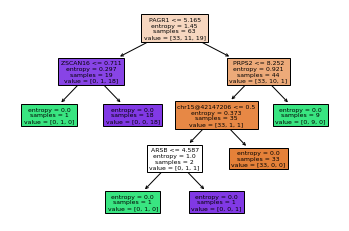

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
from random import *

rand_state =[]
acc = []
for j in range(5):
    feature_names=[i for i in df.columns]

    random_state = randint(1,100)
    rand_state.append(random_state)
    
    tree = DecisionTreeClassifier(criterion='entropy',random_state=random_state)
    tree.fit(x_train,y_train)
    tree_prediction = tree.predict(x_test)

    tree_accuracy = accuracy_score(y_test, tree_prediction)
    acc.append(tree_accuracy)
    print('Model Accuracy: {}'.format(tree_accuracy*100))
    plot_tree(tree,feature_names=feature_names,filled=True)
    print(export_text(tree, feature_names=feature_names))
    s = 'tree'+ str(random_state) + '.dot'
    #export_graphviz(tree,out_file=s, feature_names=feature_names, filled=True)

print(rand_state)
print(acc)

Model Accuracy: 87.5


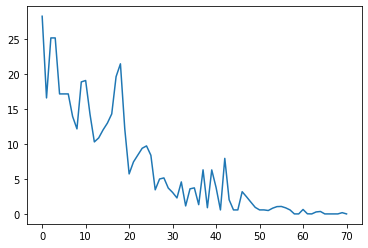

In [14]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(alpha=0.001,max_iter=100000000)
nn.fit(x_train,y_train)
nn_prediction= nn.predict(x_test)

nn_accuracy = accuracy_score(y_test, nn_prediction.round())

print('Model Accuracy: {}'.format(nn_accuracy*100))
plt.plot(nn.loss_curve_)

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
rf.fit(x_train, y_train)
rf_prediction = rf.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_prediction.round())
print('Model Accuracy: {}'.format(rf_accuracy*100))

Model Accuracy: 62.5


In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_prediction = knn.predict(x_test)
knn_accuracy = accuracy_score(y_test, knn_prediction.round())
print('Model Accuracy: {}'.format(knn_accuracy*100))

Model Accuracy: 50.0


In [17]:
import tensorflow as tf

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01,
                                              patience=3, verbose=1, restore_best_weights=True)

model = tf.keras.Sequential()

#layer 1 - input
model.add(tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.01),input_shape=[19813]))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))

#layer 2
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

#layer 6
model.add(tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

#layer 7
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

#layer - output
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Activation('softmax'))


opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer=opt,
    loss=loss,
    metrics=['accuracy']
)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Epoch 1/500
2/2 [==============================] - 1s 271ms/step - loss: 10.1603 - accuracy: 0.1830 - val_loss: 8.2912 - val_accuracy: 0.0000e+00
Epoch 2/500
2/2 [==============================] - 0s 85ms/step - loss: 8.0251 - accuracy: 0.1830 - val_loss: 6.5353 - val_accuracy: 0.0000e+00
Epoch 3/500
2/2 [==============================] - 0s 87ms/step - loss: 6.3281 - accuracy: 0.2143 - val_loss: 5.1836 - val_accuracy: 0.0000e+00
Epoch 4/500
2/2 [==============================] - 0s 88ms/step - loss: 5.0288 - accuracy: 0.2143 - val_loss: 4.1835 - val_accuracy: 0.0000e+00
Epoch 5/500
2/2 [==============================] - 0s 90ms/step - loss: 4.0742 - accuracy: 0.1726 - val_loss: 3.4823 - val_accuracy: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 92ms/step - loss: 3.4075 - accuracy: 0.1830 - val_loss: 3.0086 - val_accuracy: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 96ms/step - loss: 2.9599 - accuracy: 0.2039 - val_loss: 2.7036 - val_accuracy: 0

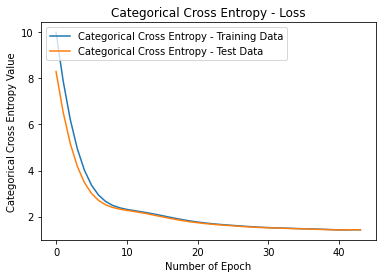

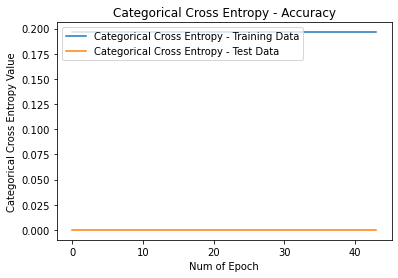

In [18]:
from sklearn.metrics import confusion_matrix

history = model.fit(x_train, y_train, validation_split=0.1,
                   epochs=500, shuffle=True, callbacks=[early_stop])

pred = model.predict(x_train)

plt.plot(history.history['loss'], label='Categorical Cross Entropy - Training Data')
plt.plot(history.history['val_loss'], label='Categorical Cross Entropy - Test Data')
plt.title('Categorical Cross Entropy - Loss')
plt.ylabel('Categorical Cross Entropy Value')
plt.xlabel('Number of Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['accuracy'], label='Categorical Cross Entropy - Training Data')
plt.plot(history.history['val_accuracy'], label='Categorical Cross Entropy - Test Data')
plt.title('Categorical Cross Entropy - Accuracy')
plt.ylabel('Categorical Cross Entropy Value')
plt.xlabel('Num of Epoch')
plt.legend(loc='upper left')
plt.show()